Apply the LBFGS algorithm to the FWI problem with $m=1$ correction pair to form the inverse Hessian matrices and with various tolerances for the gradient, namely, tol = $10^{-4}$, $0.5 \times 10^{-4}$, and $10^{-5}$, in order to determine if the defined tolerance is sufficient.

### a) tol = $10^{-4}$

In [1]:
import data
import vcl
import rsfvc
import segyvc
import asg
import npvc
import vcalg
import linalg
import numpy as np
import time
import func
import lsalg
import optimizationAlg
import os

start_time = time.time()

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
                          
# # scale the source
linalg.scale('wstar.su',1000)


# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')


# the number of vector pair {s,y} we want to keep
m = 1
k = 0


# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')


# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)


# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# reset initial m
mest = vcl.Vector(bulksp)
mest.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
mest.linComb(t,mstar,1.0-t)


# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp = rsfvc.Space('cx.rsf')


# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf',
cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)
# initial expanded velo model, corresponding to m
cx7 = inv(mest)


# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf',
                    cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)

# least-squares function
JFWI = vcl.LeastSquares(Fmod,dstar)



alpha = 1.0
c = 0.0001
iterMax = 100
verbose = 1
beta = 0.5
eps = 0.00000000000001
Kmax = 1200
tol = 0.0001
plot_on = 0 #  plot for the solution
gamma = 1

cx7 = optimizationAlg.lbfgs(JFWI, cx7, m, bulksp, cxsp, iterMax,
                            alpha, beta, c, verbose, eps, gamma, tol, Kmax, plot_on)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The total run time for program is {elapsed_time} sec.")


 
Iteration 1 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.093455 dfp = -2.77983e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.093455    f(x)-f(xn)=2.7499999999999747e-05
||p||=0.0052724093164321     ||df||=0.0052724093164321    dfp=-2.77983e-05 
c*alpha*dfp=-2.7798300000000003e-09
 
k = 1 alpha = 1.0 f(xn) = 0.0934275 ||df|| = 0.005267864842609385
The total run time for this line search is: 32.178755044937134 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 2 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0934275 dfp = -0.0378611
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0934275    f(x)-f(xn)=0.025161000000000003
||p||=7.554766707185603     ||df||=0.005267864842609385    dfp=-0.0378611 
c*alpha*dfp=-3.7861100000000003e-06
 
k = 2 alp

||p||=2.92481452403396     ||df||=0.0002237103037412448    dfp=-0.000433782 
c*alpha*dfp=-4.3378200000000004e-08
 
k = 13 alpha = 1.0 f(xn) = 0.001043325 ||df|| = 0.00015052607747496777
The total run time for this line search is: 33.074427127838135 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 14 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.001043325 dfp = -0.000272942
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.001043325    f(x)-f(xn)=0.00019350999999999993
||p||=2.373861832542071     ||df||=0.00015052607747496777    dfp=-0.000272942 
c*alpha*dfp=-2.72942e-08
 
k = 14 alpha = 1.0 f(xn) = 0.000849815 ||df|| = 0.00022995042944078188
The total run time for this line search is: 33.17449116706848 sec.
-----------------------------------------------------------------------------
-----------------------

 
 The initial slowness:
 
colmax=4.5 colmin=2.5


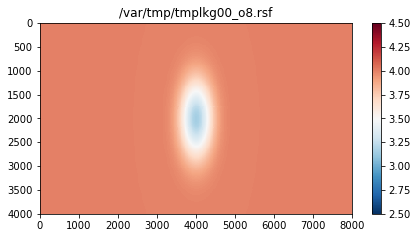

simplot: data min = 3.1607e+00, data max = 4.0000e+00


In [2]:
mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)

print(" ")
print(" The initial slowness:")
print(" ")
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

 
 The estimated slowness from LBFGS:
 
colmax=4.5 colmin=2.5


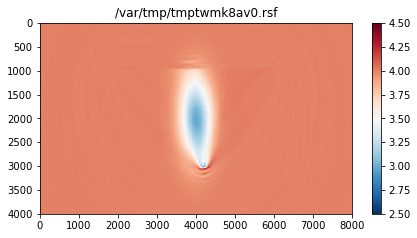

simplot: data min = 2.9878e+00, data max = 4.2052e+00


In [3]:
# plot result of LBFGS, translated to bulkmod
mfin7 = fwd(cx7)
print(" ")
print(" The estimated slowness from LBFGS:")
print(" ")
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

 
 The target slowness:
 
colmax=4.5 colmin=2.5


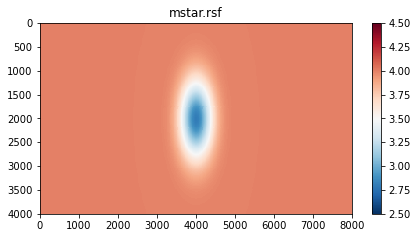

simplot: data min = 2.8009e+00, data max = 4.0000e+00


In [4]:
print(" ")
print(" The target slowness:")
print(" ")
# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

 
 The initial data:
 
colmax=0.004 colmin=-0.004


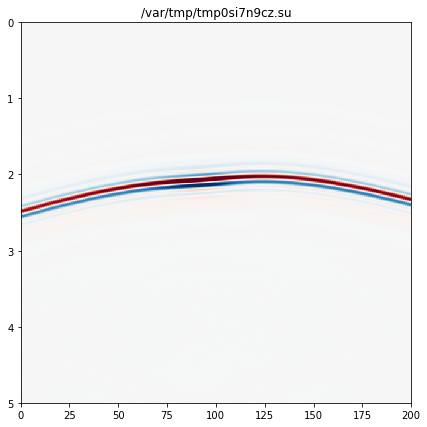

simplot: data min = -5.4178e-03, data max = 6.7892e-03
simplot: clip = 4.0000e-03
 
 The estimated data:
 
colmax=0.004 colmin=-0.004


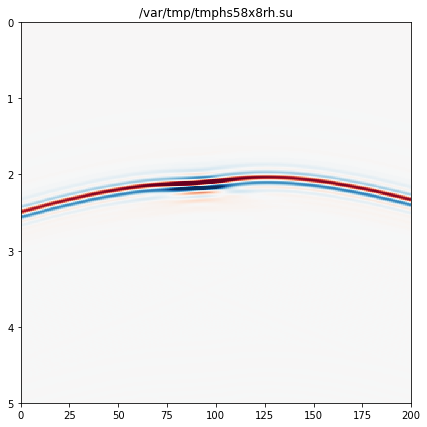

simplot: data min = -7.6236e-03, data max = 8.4057e-03
simplot: clip = 4.0000e-03
 
 The difference between the initial data and the true data:
 
colmax=0.004 colmin=-0.004


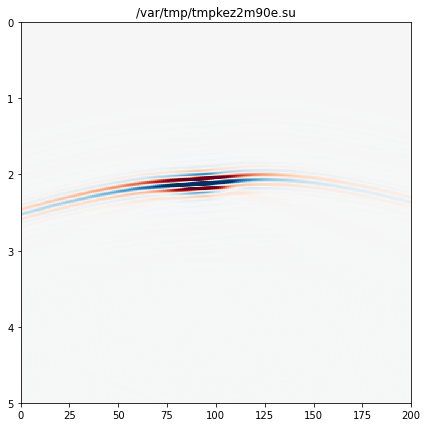

simplot: data min = -1.0579e-02, data max = 7.3968e-03
simplot: clip = 4.0000e-03
 
 The difference between the estimated data and the true data:
 
colmax=0.004 colmin=-0.004


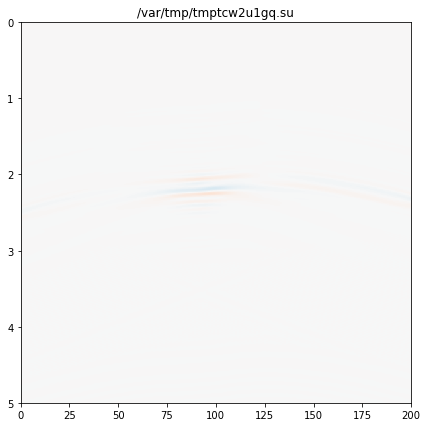

simplot: data min = -6.5317e-04, data max = 5.6396e-04
simplot: clip = 4.0000e-03
initial relative error = 1.9203e-05
final relative error   = 1.3577e-06


In [5]:
dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7=dbeg7.dup()
rbeg7.linComb(-1.0,dstar)
rfin7=dfin7.dup()
rfin7.linComb(-1.0,dstar)

print(" ")
print(" The initial data:")
print(" ")
linalg.simplot(dbeg7.data,clip=4.0e-3)
print(" ")
print(" The estimated data:")
print(" ")
linalg.simplot(dfin7.data,clip=4.0e-3)
print(" ")
print(" The difference between the initial data and the true data:")
print(" ")
linalg.simplot(rbeg7.data,clip=4.0e-3)
print(" ")
print(" The difference between the estimated data and the true data:")
print(" ")
linalg.simplot(rfin7.data,clip=4.0e-3)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))

### b) tol = $0.5 \times 10^{-4}$

In [6]:
import data
import vcl
import rsfvc
import segyvc
import asg
import npvc
import vcalg
import linalg
import numpy as np
import time
import func
import lsalg
import optimizationAlg
import os

start_time = time.time()

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
                          
# # scale the source
linalg.scale('wstar.su',1000)


# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')


# the number of vector pair {s,y} we want to keep
m = 1
k = 0


# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')


# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)


# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# reset initial m
mest = vcl.Vector(bulksp)
mest.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
mest.linComb(t,mstar,1.0-t)


# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp = rsfvc.Space('cx.rsf')


# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf',
cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)
# initial expanded velo model, corresponding to m
cx7 = inv(mest)


# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf',
                    cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)

# least-squares function
JFWI = vcl.LeastSquares(Fmod,dstar)



alpha = 1.0
c = 0.0001
iterMax = 100
verbose = 1
beta = 0.5
eps = 0.00000000000001
Kmax = 1200
tol = 0.5*0.0001
plot_on = 0 #  plot for the solution
gamma = 1

cx7 = optimizationAlg.lbfgs(JFWI, cx7, m, bulksp, cxsp, iterMax,
                            alpha, beta, c, verbose, eps, gamma, tol, Kmax, plot_on)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The total run time for program is {elapsed_time} sec.")


 
Iteration 1 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.093455 dfp = -2.77983e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.093455    f(x)-f(xn)=2.7499999999999747e-05
||p||=0.0052724093164321     ||df||=0.0052724093164321    dfp=-2.77983e-05 
c*alpha*dfp=-2.7798300000000003e-09
 
k = 1 alpha = 1.0 f(xn) = 0.0934275 ||df|| = 0.005267864842609385
The total run time for this line search is: 33.917598247528076 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 2 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0934275 dfp = -0.0378611
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0934275    f(x)-f(xn)=0.025161000000000003
||p||=7.554766707185603     ||df||=0.005267864842609385    dfp=-0.0378611 
c*alpha*dfp=-3.7861100000000003e-06
 
k = 2 alp

||p||=2.92481452403396     ||df||=0.0002237103037412448    dfp=-0.000433782 
c*alpha*dfp=-4.3378200000000004e-08
 
k = 13 alpha = 1.0 f(xn) = 0.001043325 ||df|| = 0.00015052607747496777
The total run time for this line search is: 35.44901084899902 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 14 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.001043325 dfp = -0.000272942
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.001043325    f(x)-f(xn)=0.00019350999999999993
||p||=2.373861832542071     ||df||=0.00015052607747496777    dfp=-0.000272942 
c*alpha*dfp=-2.72942e-08
 
k = 14 alpha = 1.0 f(xn) = 0.000849815 ||df|| = 0.00022995042944078188
The total run time for this line search is: 34.04447793960571 sec.
-----------------------------------------------------------------------------
------------------------

 
Iteration 25 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0002692615 dfp = -3.64494e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0002692615    f(x)-f(xn)=2.456299999999996e-05
||p||=1.2138739638034914     ||df||=9.298510633429421e-05    dfp=-3.64494e-05 
c*alpha*dfp=-3.64494e-09
 
k = 25 alpha = 1.0 f(xn) = 0.0002446985 ||df|| = 8.876378766141067e-05
The total run time for this line search is: 34.39676380157471 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 26 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0002446985 dfp = -4.25925e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0002446985    f(x)-f(xn)=3.2619500000000015e-05
||p||=1.9032445980482908     ||df||=8.876378766141067e-05    dfp=-4.25925e-05 
c*alpha*dfp=-4.2592500000000

 
 The initial slowness:
 
colmax=4.5 colmin=2.5


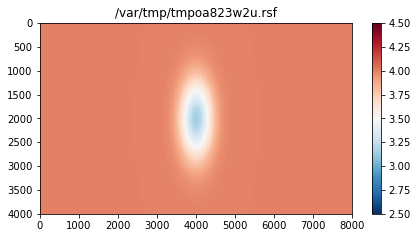

simplot: data min = 3.1607e+00, data max = 4.0000e+00


In [9]:
mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)

print(" ")
print(" The initial slowness:")
print(" ")
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

 
 The estimated slowness from LBFGS:
 
colmax=4.5 colmin=2.5


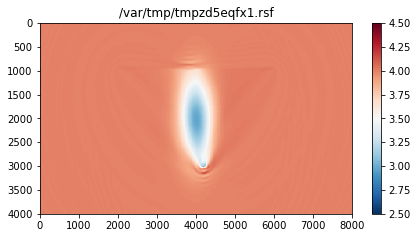

simplot: data min = 2.9713e+00, data max = 4.1436e+00


In [10]:
# plot result of LBFGS, translated to bulkmod
mfin7 = fwd(cx7)
print(" ")
print(" The estimated slowness from LBFGS:")
print(" ")
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

 
 The target slowness:
 
colmax=4.5 colmin=2.5


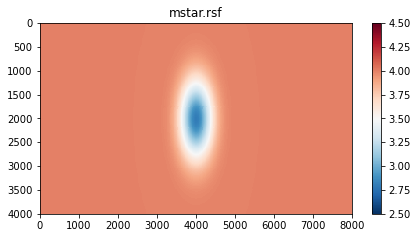

simplot: data min = 2.8009e+00, data max = 4.0000e+00


In [11]:
print(" ")
print(" The target slowness:")
print(" ")
# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

 
 The initial data:
 
colmax=0.004 colmin=-0.004


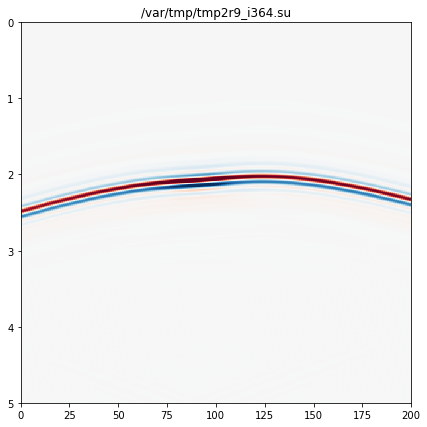

simplot: data min = -5.4178e-03, data max = 6.7892e-03
simplot: clip = 4.0000e-03
 
 The estimated data:
 
colmax=0.004 colmin=-0.004


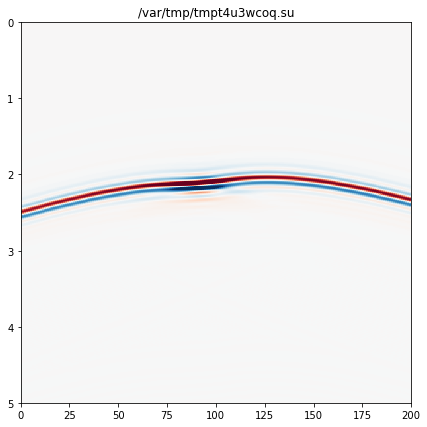

simplot: data min = -7.4897e-03, data max = 8.5335e-03
simplot: clip = 4.0000e-03
 
 The difference between the initial data and the true data:
 
colmax=0.004 colmin=-0.004


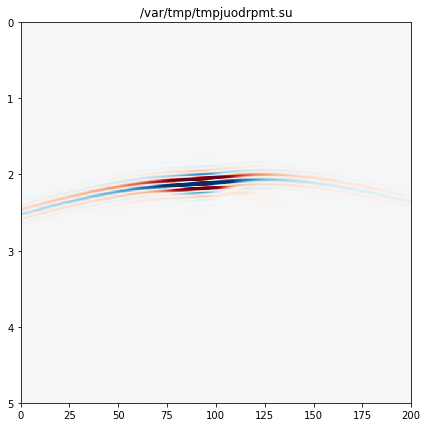

simplot: data min = -1.0579e-02, data max = 7.3968e-03
simplot: clip = 4.0000e-03
 
 The difference between the estimated data and the true data:
 
colmax=0.004 colmin=-0.004


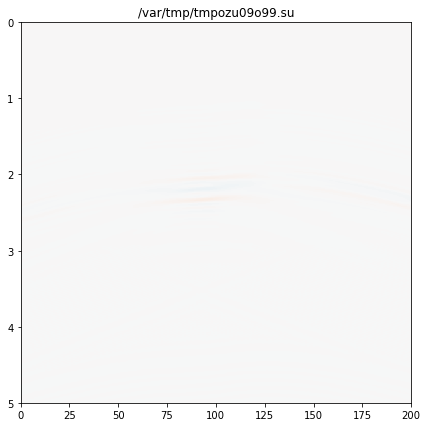

simplot: data min = -2.5022e-04, data max = 2.7907e-04
simplot: clip = 4.0000e-03
initial relative error = 1.9203e-05
final relative error   = 7.1031e-07


In [12]:
dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7=dbeg7.dup()
rbeg7.linComb(-1.0,dstar)
rfin7=dfin7.dup()
rfin7.linComb(-1.0,dstar)

print(" ")
print(" The initial data:")
print(" ")
linalg.simplot(dbeg7.data,clip=4.0e-3)
print(" ")
print(" The estimated data:")
print(" ")
linalg.simplot(dfin7.data,clip=4.0e-3)
print(" ")
print(" The difference between the initial data and the true data:")
print(" ")
linalg.simplot(rbeg7.data,clip=4.0e-3)
print(" ")
print(" The difference between the estimated data and the true data:")
print(" ")
linalg.simplot(rfin7.data,clip=4.0e-3)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))

### c) tol = $10^{-5}$

In [14]:
import data
import vcl
import rsfvc
import segyvc
import asg
import npvc
import vcalg
import linalg
import numpy as np
import time
import func
import lsalg
import optimizationAlg
import os

start_time = time.time()

# bulk modulus with lens
data.model(bulkfile='mstar.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=0.7)

# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
                          
# # scale the source
linalg.scale('wstar.su',1000)


# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='data.su',nt=626,dt=8.0,ntr=201,rx=2000,rz=1000,sx=4200,sz=3000,drx=20)
    
# domain and range spaces
bulksp = rsfvc.Space('mstar.rsf')
datasp = segyvc.Space('data.su')


# the number of vector pair {s,y} we want to keep
m = 1
k = 0


# wrap bulk modulus in Vector
mstar = vcl.Vector(bulksp,'mstar.rsf')


# instantial modeling operator
F = asg.fsbop(dom=bulksp, rng=datasp, \
            buoyancy='bymstar.rsf', source_p='wstar.su', \
            order=2, sampord=1, nsnaps=20,\
            cfl=0.5, cmin=1.0, cmax=3.0,dmin=0.8, dmax=3.0,\
            nl1=250, nr1=250, nl2=250, nr2=250, pmlampl=1.0)


# evaluate F[mstar], create noise-free data
dstar = F(mstar)

# homogeneous bulk modulus
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20,
           lensfac=1.0)
m0 = vcl.Vector(bulksp,'m0.rsf')

# reset initial m
mest = vcl.Vector(bulksp)
mest.copy(m0)
t = 0.7
# m = t*mstar + (1-t)*m0
mest.linComb(t,mstar,1.0-t)


# create header file to define expanded velo space
os.system('sfput < mstar.rsf label="Real" unit="None" > cx.rsf')
cxsp = rsfvc.Space('cx.rsf')


# inverse map expanded c from bulkmod
inv = asg.invrntobulkfb(bulksp, cxsp, 'bymstar.rsf',
cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)
# initial expanded velo model, corresponding to m
cx7 = inv(mest)


# forward map expanded c to bulkmod
fwd = asg.rntobulkfb(cxsp, bulksp, 'bymstar.rsf',
                    cmin=1.0, cmax=3.0, dmin=0.8, dmax=3.0)

# composition: modeling on expanded velo space
Fmod = vcl.comp(F, fwd)

# least-squares function
JFWI = vcl.LeastSquares(Fmod,dstar)



alpha = 1.0
c = 0.0001
iterMax = 100
verbose = 1
beta = 0.5
eps = 0.00000000000001
Kmax = 1200
tol = 0.00001
plot_on = 0 #  plot for the solution
gamma = 1

cx7 = optimizationAlg.lbfgs(JFWI, cx7, m, bulksp, cxsp, iterMax,
                            alpha, beta, c, verbose, eps, gamma, tol, Kmax, plot_on)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The total run time for program is {elapsed_time} sec.")


 
Iteration 1 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.093455 dfp = -2.77983e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.093455    f(x)-f(xn)=2.7499999999999747e-05
||p||=0.0052724093164321     ||df||=0.0052724093164321    dfp=-2.77983e-05 
c*alpha*dfp=-2.7798300000000003e-09
 
k = 1 alpha = 1.0 f(xn) = 0.0934275 ||df|| = 0.005267864842609385
The total run time for this line search is: 36.62333393096924 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 2 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0934275 dfp = -0.0378611
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0934275    f(x)-f(xn)=0.025161000000000003
||p||=7.554766707185603     ||df||=0.005267864842609385    dfp=-0.0378611 
c*alpha*dfp=-3.7861100000000003e-06
 
k = 2 alph

||p||=2.92481452403396     ||df||=0.0002237103037412448    dfp=-0.000433782 
c*alpha*dfp=-4.3378200000000004e-08
 
k = 13 alpha = 1.0 f(xn) = 0.001043325 ||df|| = 0.00015052607747496777
The total run time for this line search is: 33.79919719696045 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 14 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.001043325 dfp = -0.000272942
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.001043325    f(x)-f(xn)=0.00019350999999999993
||p||=2.373861832542071     ||df||=0.00015052607747496777    dfp=-0.000272942 
c*alpha*dfp=-2.72942e-08
 
k = 14 alpha = 1.0 f(xn) = 0.000849815 ||df|| = 0.00022995042944078188
The total run time for this line search is: 33.35490298271179 sec.
-----------------------------------------------------------------------------
------------------------

 
Iteration 25 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0002692615 dfp = -3.64494e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0002692615    f(x)-f(xn)=2.456299999999996e-05
||p||=1.2138739638034914     ||df||=9.298510633429421e-05    dfp=-3.64494e-05 
c*alpha*dfp=-3.64494e-09
 
k = 25 alpha = 1.0 f(xn) = 0.0002446985 ||df|| = 8.876378766141067e-05
The total run time for this line search is: 36.642956018447876 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 26 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.0002446985 dfp = -4.25925e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.0002446985    f(x)-f(xn)=3.2619500000000015e-05
||p||=1.9032445980482908     ||df||=8.876378766141067e-05    dfp=-4.25925e-05 
c*alpha*dfp=-4.259250000000

 
Iteration 36 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 0.000108385 dfp = -1.00092e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=0.000108385    f(x)-f(xn)=8.656000000000007e-06
||p||=0.3940063451265728     ||df||=9.227767877444686e-05    dfp=-1.00092e-05 
c*alpha*dfp=-1.00092e-09
 
k = 36 alpha = 1.0 f(xn) = 9.9729e-05 ||df|| = 5.801594608381389e-05
The total run time for this line search is: 36.08069729804993 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 37 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 9.9729e-05 dfp = -2.43873e-05
 
During Line Search:
 
i=0    alpha=1.0   f(x)=9.9729e-05    f(x)-f(xn)=1.3597999999999987e-05
||p||=1.5295751043999115     ||df||=5.801594608381389e-05    dfp=-2.43873e-05 
c*alpha*dfp=-2.43873e-09
 
k = 37 al

k = 48 alpha = 1.0 f(xn) = 4.41199e-05 ||df|| = 1.880736557841103e-05
The total run time for this line search is: 34.493870973587036 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 49 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 4.41199e-05 dfp = -6.86556e-07
 
During Line Search:
 
i=0    alpha=1.0   f(x)=4.41199e-05    f(x)-f(xn)=4.600999999999992e-07
||p||=0.038080047268878224     ||df||=1.880736557841103e-05    dfp=-6.86556e-07 
c*alpha*dfp=-6.86556e-11
 
k = 49 alpha = 1.0 f(xn) = 4.36598e-05 ||df|| = 1.2808903153666203e-05
The total run time for this line search is: 34.68028903007507 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 50 of LBFGS:
i is the iteration counter for line

 
Iteration 61 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 2.68794e-05 dfp = -1.38762e-06
 
During Line Search:
 
i=0    alpha=1.0   f(x)=2.68794e-05    f(x)-f(xn)=8.394499999999975e-07
||p||=0.31215012413901105     ||df||=2.1047232597184836e-05    dfp=-1.38762e-06 
c*alpha*dfp=-1.38762e-10
 
k = 61 alpha = 1.0 f(xn) = 2.603995e-05 ||df|| = 1.2428233985566896e-05
The total run time for this line search is: 33.80775189399719 sec.
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
 
Iteration 62 of LBFGS:
i is the iteration counter for line search.
 
Before Line Search:
i = 0 alpha = 0 f(x) =  + 2.603995e-05 dfp = -5.89204e-07
 
During Line Search:
 
i=0    alpha=1.0   f(x)=2.603995e-05    f(x)-f(xn)=4.936500000000016e-07
||p||=0.2503751185721137     ||df||=1.2428233985566896e-05    dfp=-5.89204e-07 
c*alpha*dfp=-5.89204e-11
 


 
 The initial slowness:
 
colmax=4.5 colmin=2.5


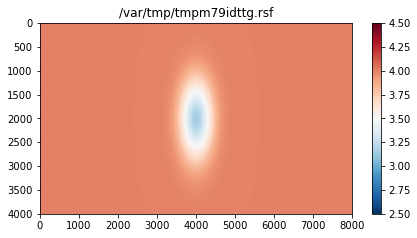

simplot: data min = 3.1607e+00, data max = 4.0000e+00


In [15]:
mbeg7=vcl.Vector(bulksp)
mbeg7.copy(m0)
t = 0.7
mbeg7.linComb(t,mstar,1.0-t)

print(" ")
print(" The initial slowness:")
print(" ")
linalg.simplot(mbeg7.data, addcb=True, minval=2.5, maxval=4.5)

 
 The estimated slowness from LBFGS:
 
colmax=4.5 colmin=2.5


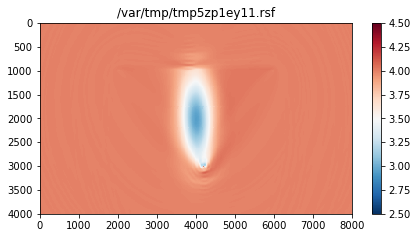

simplot: data min = 2.9511e+00, data max = 4.0934e+00


In [16]:
# plot result of LBFGS, translated to bulkmod
mfin7 = fwd(cx7)
print(" ")
print(" The estimated slowness from LBFGS:")
print(" ")
linalg.simplot(mfin7.data, addcb=True, minval=2.5, maxval=4.5)

 
 The target slowness:
 
colmax=4.5 colmin=2.5


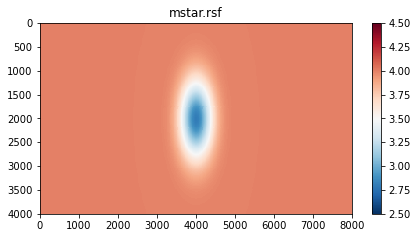

simplot: data min = 2.8009e+00, data max = 4.0000e+00


In [17]:
print(" ")
print(" The target slowness:")
print(" ")
# plot target bulk mod
linalg.simplot(mstar.data, addcb=True, minval=2.5, maxval=4.5)

 
 The initial data:
 
colmax=0.004 colmin=-0.004


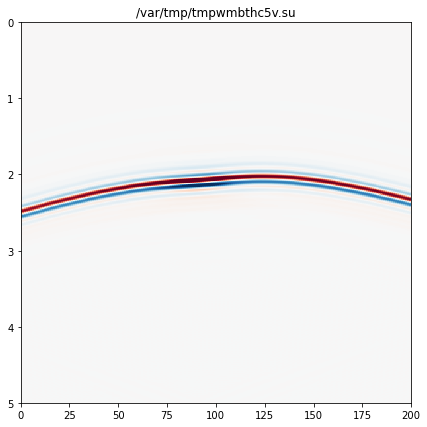

simplot: data min = -5.4178e-03, data max = 6.7892e-03
simplot: clip = 4.0000e-03
 
 The estimated data:
 
colmax=0.004 colmin=-0.004


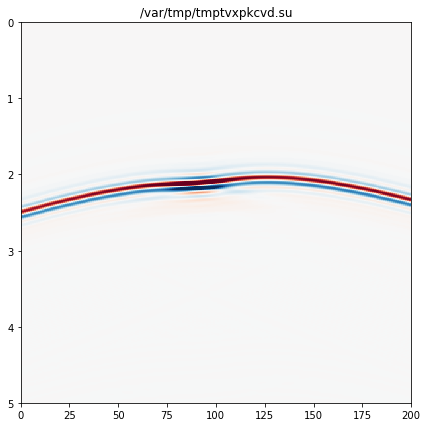

simplot: data min = -7.3845e-03, data max = 8.5883e-03
simplot: clip = 4.0000e-03
 
 The difference between the initial data and the true data:
 
colmax=0.004 colmin=-0.004


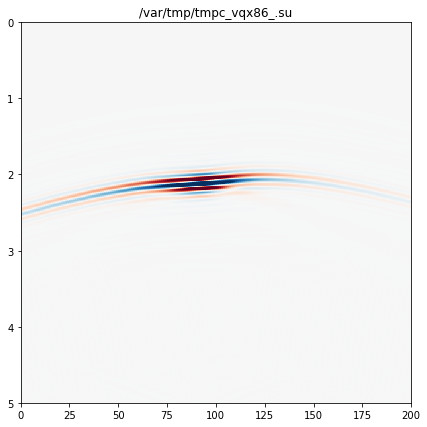

simplot: data min = -1.0579e-02, data max = 7.3968e-03
simplot: clip = 4.0000e-03
 
 The difference between the estimated data and the true data:
 
colmax=0.004 colmin=-0.004


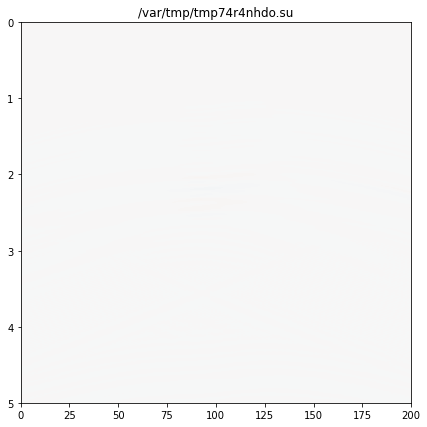

simplot: data min = -7.5525e-05, data max = 6.9064e-05
simplot: clip = 4.0000e-03
initial relative error = 1.9203e-05
final relative error   = 2.9165e-07


In [18]:
dbeg7 = F(mbeg7)
dfin7 = F(mfin7)
rbeg7=dbeg7.dup()
rbeg7.linComb(-1.0,dstar)
rfin7=dfin7.dup()
rfin7.linComb(-1.0,dstar)

print(" ")
print(" The initial data:")
print(" ")
linalg.simplot(dbeg7.data,clip=4.0e-3)
print(" ")
print(" The estimated data:")
print(" ")
linalg.simplot(dfin7.data,clip=4.0e-3)
print(" ")
print(" The difference between the initial data and the true data:")
print(" ")
linalg.simplot(rbeg7.data,clip=4.0e-3)
print(" ")
print(" The difference between the estimated data and the true data:")
print(" ")
linalg.simplot(rfin7.data,clip=4.0e-3)

print('initial relative error = %10.4e' % (rbeg7.norm()/mstar.norm()))
print('final relative error   = %10.4e' % (rfin7.norm()/mstar.norm()))